In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
plt.rcParams['figure.figsize'] = [10, 5]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

The fuzzy approach is particularly appropriate where the mathematical model of the plant does not exist, or is ill-defined, the system is nonlinear, complex and multi-dimensional and has parameter variation problem, or the system generates comples output where simple and straightforward estimation is not possible.

A fuzzy logic system has foour blocks:

- Fuzzification
- Decision-Making-Logic 
- Defuzzification
- Knowledge Base

The input variables are valuated with the correspondent membership values for each input fuzzy set. The decision-making-logic together with the knowledge base determine the outputs of each fuzzy IF-THEN rules, which are combined and converted to crisp values with the defuzzification block.

Of course, the fuzzy estimation is based on heuristic or trial-and-error approach, and therefore, the algorithm development may be time-consuming, and often accuracy may be limited.

A Fuzzy Neural Network (FuzzyNN) applies neural network principles to fuzzy reasoning. It emulates a fuzzy logic controller in the neural network topology. The FNN has a structure in a such way that it directly maps weights of different layers into the required membership functions and fuzzy rules, relieving the designer of the task of assigning and generating those membership functions and fuzzy rules.




# Fuzzy Neural Networks

### Premises

Figure 1. shows the configuration of the premises of the proposed FNN's. The network consists of five layers and uses the backpropagation for learning. The figure shows the case where the premise have two-inputs x1, x2 and three membership functions on each premise.

![Fuzzy-NN Premise](./imgs/fuzzy_nn_premise.png)

The outputs of the units with a symbol $\Sigma$ are sums of their inputs. Those with $\Pi$ are products of their inputs. The units without any symbol just deliver their inputs to succeeding layers. ws, wc, wg and 1, -1 are connection weights. ws, wc and wg are to be modified through learning. The inputs into (A)-layer xj are biased by wc in (C)-layer and are multiplied with wg. The results are outputs in (D) layer are rewritten as:
$ f(x_j) = 1 / (1 + exp(-wg(ws * x_j + wc)) $

At (F)-layer the truth values in the premises are obtained as the products of the grades of the membership functions. The number of the units in (F)-layer are determined by the combination of the membership functions in the premises $n_F = m**n_{in}$ where $m$ is the number of memberships in each premise and $n_{in}$ is the number of input variables.

### Let's visualize the effect of tunning wc, wg, ws 

First we define the forward pass from layer (A) to (D).

In [2]:
import math 
import numpy as np

def sig(x, wc, wg):
    return 1 / (1 + math.e**(-wg*(x+wc)))

The first parameter that we'll be tuning to see what impact has on the membership function is: wc

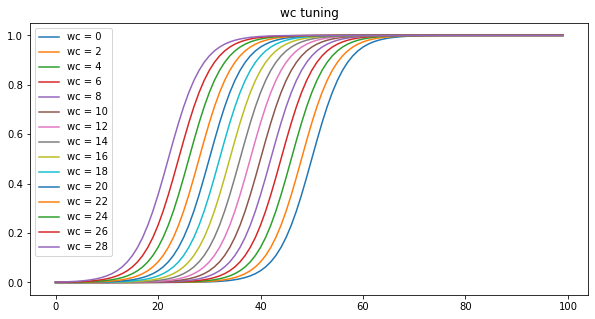

In [3]:
for wc_i in np.arange(0,30, 2):
    plt.plot(sig(np.array([range(-50,+50)]), wc_i, 0.3).squeeze(), label=f'wc = {wc_i}')

plt.legend()
plt.title(f'wc tuning')
plt.show()
    

Observamos que w_c nos permite desplazar la sigmoid en el rango de valores que puede tomar la entrada x. De esta forma podemos controlar la membresía.
Por ejemplo:

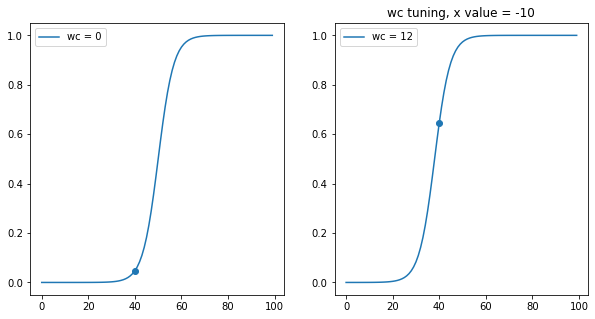

In [4]:
fig, axs = plt.subplots(1,2)

axs[0].plot(sig(np.array([range(-50,+50)]), 0, 0.3).squeeze(), label=f'wc = 0')
axs[0].scatter(x=40, y=sig(np.array([-10]), 0, 0.3).squeeze())
axs[0].legend()

axs[1].plot(sig(np.array([range(-50,+50)]), 12, 0.3).squeeze(), label=f'wc = 12')
axs[1].scatter(x=40, y=sig(np.array([-10]), 12, 0.3).squeeze())
axs[1].legend()

plt.title(f'wc tuning, x value = -10')
plt.show()

The second parameter that we'll be tuning to see what impact has on the membership function is: wg

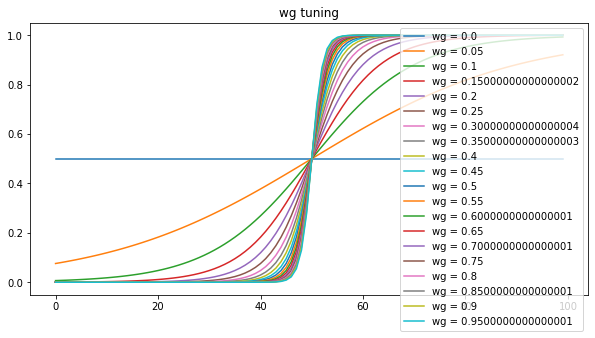

In [5]:
for wg_i in np.arange(0,1, 0.05):
    plt.plot(sig(np.array([range(-50,+50)]), 0, wg_i).squeeze(), label=f'wg = {wg_i}')

plt.legend()
plt.title(f'wg tuning')
plt.show()

Observamos que w_g nos permite controlar la pendiente de la sigmoid en el rango de valores que puede tomar la entrada x. De esta forma podemos controlar la membresía.
Por ejemplo:

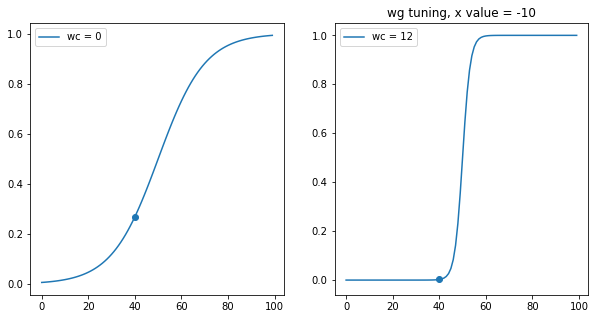

In [6]:
fig, axs = plt.subplots(1,2)

axs[0].plot(sig(np.array([range(-50,+50)]), 0, 0.1).squeeze(), label=f'wc = 0')
axs[0].scatter(x=40, y=sig(np.array([-10]), 0, 0.1).squeeze())
axs[0].legend()

axs[1].plot(sig(np.array([range(-50,+50)]), 0, 0.6).squeeze(), label=f'wc = 12')
axs[1].scatter(x=40, y=sig(np.array([-10]), 0, 0.6).squeeze())
axs[1].legend()

plt.title(f'wg tuning, x value = -10')
plt.show()

In [7]:
def relu(x, wc, wg):
    return np.clip((-wg*(x+wc)), a_min=0, a_max=1)

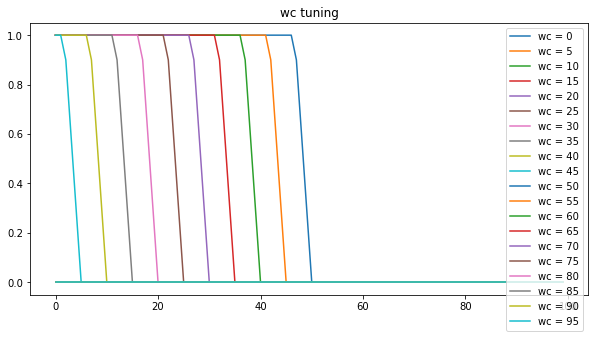

In [8]:
for wc_i in np.arange(0,100, 5):
    plt.plot(relu(np.array([range(-50,+50)]), wc_i, 0.3).squeeze(), label=f'wc = {wc_i}')

plt.legend()
plt.title(f'wc tuning')
plt.show()

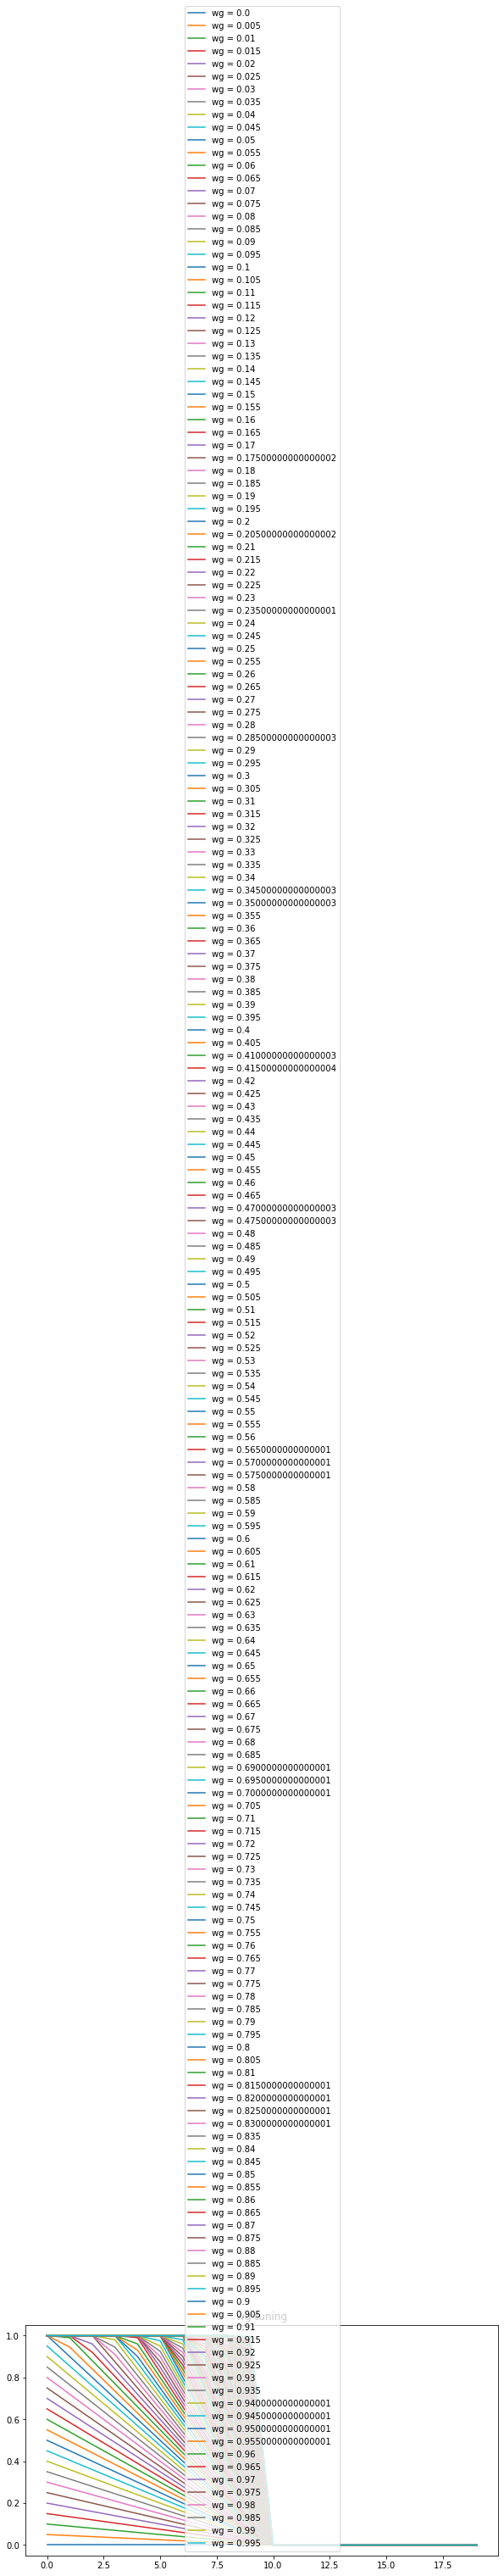

In [9]:
for wg_i in np.arange(0,1, 0.005):
    plt.plot(relu(np.array([range(-10,+10)]), 0, wg_i).squeeze(), label=f'wg = {wg_i}')

plt.legend()
plt.title(f'wg tuning')
plt.show()

### FUZZY-NN PREMISES GENERATOR

The purpose of this generator is to generate the premises, as NN but parameterized by:

In [10]:
class Point(nn.Module):
    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = y
    

In [11]:
class MembershipTriangular(nn.Module):
    """
    Mermbership triangular function for a universe of discourse in a fuzzy control system.
    It should be initialized by the Premise class.

    Parameters
    ----------
    label : string. name of the membership function.
    min_value: minimum value of the membership function.
    central_value: central value of the membership function.
    max_value: maximum value of the membership function.
    """
    def __init__(self, label, min_value, central_value, max_value):
        super().__init__()
        self.label= label
        self.min = Point(nn.Parameter(torch.Tensor([min_value])), 0.0)
        self.central = Point(nn.Parameter(torch.Tensor([central_value])), 1.0)
        self.max = Point(nn.Parameter(torch.Tensor([max_value])), 0.0)
        
    def forward(self, x):
        m_left = (self.central.y - self.min.y) / (self.central.x - self.min.x)
        m_right = (self.max.y - self.central.y) / (self.max.x - self.central.x)
        # y = m * (x - x0) + y0
        y_left = lambda x: m_left * (x - self.min.x) + self.min.y
        y_right = lambda x: m_right * (x - self.central.x) + self.central.y
        y = torch.where(x < self.central.x, y_left(x), y_right(x))
        y = torch.clamp(y, min=0.0, max=1.0)
        return y
    
    def plot(self, axs, scale=None):
        with torch.no_grad():
            xs = np.arange(-1.0, 1.0, 0.05) 
            min_lbl = self.min.x.item()
            central_lbl = self.central.x.item()
            max_lbl = self.max.x.item()
            if scale is not None: 
                xs = scale(xs)
                min_lbl = scale(min_lbl)
                central_lbl = scale(central_lbl)
                max_lbl = scale(max_lbl)
            min_lbl = round(min_lbl, 2)
            central_lbl = round(central_lbl, 2)
            max_lbl = round(max_lbl, 2)
            axs.plot(xs, self.forward(torch.arange(-1,1,0.05)).squeeze().cpu().detach().numpy(), label=f'{self.label}: ({min_lbl},{central_lbl},{max_lbl})')

        

In [12]:
mf = MembershipTriangular(label='prueba', min_value=-0.7, central_value=0.0, max_value=0.5)

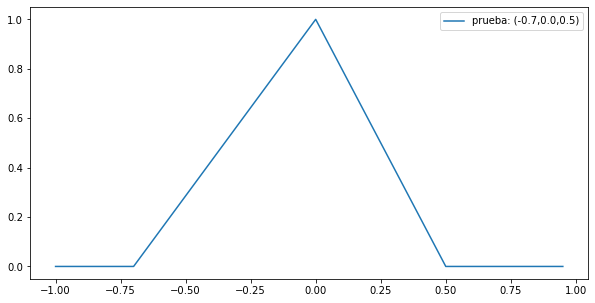

In [13]:
fig, axs = plt.subplots()

mf.plot(axs)

plt.legend()
plt.show()

In [14]:
class Rescale(object):
    """
    Scales the input to a given range.
    """
    def __init__(self, max_new, min_new, max_old, min_old):
        self.max_new = max_new
        self.min_new = min_new
        self.max_old = max_old
        self.min_old = min_old
    
    def __call__(self, x):
        return ((self.max_new - self.min_new) / (self.max_old - self.min_old)) * (x - self.max_old) + self.max_new

In [15]:
class Premise(nn.Module):
    """
    Premise variable for a fuzzy control system.

    Parameters
    ----------
    universe_name : string. name of the universe of discourse.
    min_value: minimum value of the universe of discourse.
    max_value: maximum value of the universe of discourse.
    memberships: list of string labels to name the memberships.
    """
    
    def __init__(self, universe_name, min_value, max_value):
        super().__init__()
        self.universe_name = universe_name
        self.min_value = min_value
        self.max_value = max_value
        self.epsilon = 0.00001
        self.memberships = nn.ModuleList()
        self.rescale = Rescale(max_new=1.0, 
                               min_new=-1.0, 
                               max_old=self.max_value, 
                               min_old=self.min_value)
        
    
    def forward(self, x):
        # As some obs variables can go to infinity, 
        # We clamp values to the range of min_value max_value
        x = torch.clamp(x, min=self.min_value+self.epsilon, max=self.max_value-self.epsilon)
        # Rescale input to [-1.0, 1.0]
        x = self.rescale(x)
        # forward thru memberships
        out = torch.stack([mf(x) for mf in self.memberships])
        return out
    
    def add_membership(self, label, min_value, central_value, max_value):    
        mf = MembershipTriangular(label, 
                                  self.rescale(min_value),
                                  self.rescale(central_value),
                                  self.rescale(max_value))
        self.memberships.add_module(mf.label, mf)
        
    
    def auto_memberships(self, labels):
        centers = np.linspace(self.min_value, self.max_value, len(labels))
        bases = np.linspace(self.min_value, self.max_value, len(labels) * 2)
        
        for i, label in enumerate(labels):

            min_value_idx = i if i < 2 else i + (i-1)            
            #max_value_idx 
            if i == len(labels) - 1:
                max_value_idx = -1
            elif i == 0:
                max_value_idx = min_value_idx + 2
            else:
                max_value_idx = min_value_idx + 3
                
            central_value = centers[i]
            min_value = bases[min_value_idx]
            max_value = bases[max_value_idx]
            
            mf = MembershipTriangular(label, 
                                      self.rescale(min_value),
                                      self.rescale(central_value),
                                      self.rescale(max_value))
            
            self.memberships.add_module(mf.label, mf)
                                
    def plot(self):
        rescale = Rescale(max_new=self.max_value, 
                               min_new=self.min_value, 
                               max_old=1.0,
                               min_old=-1.0)
         
        fig, axs = plt.subplots()
        for mf in self.memberships:
            mf.plot(axs, scale=rescale)
        plt.legend()
        plt.title(self.universe_name)
        plt.show()
    

In [16]:
force = Premise(universe_name='Force', min_value=0.0, max_value=225.0)
force.add_membership(label='very_low', min_value=0.0, central_value=0.0, max_value=30.0)
force.add_membership(label='low', min_value=10.0, central_value=30.0, max_value=50.0)
force.add_membership(label='medium', min_value=40.0, central_value=70.0, max_value=100.0)
force.add_membership(label='high', min_value=90.0, central_value=140.0, max_value=160.0)
force.add_membership(label='very_high', min_value=150.0, central_value=225.0, max_value=225.0)

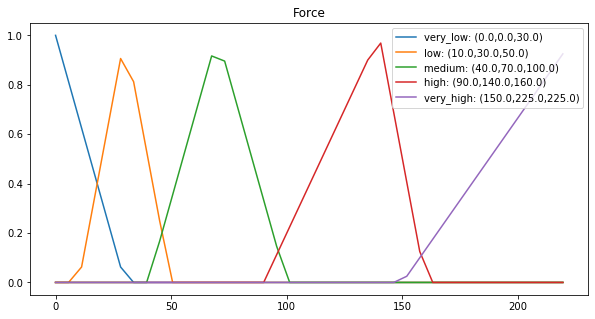

In [17]:
force.plot()

In [18]:
for n, param in force.named_parameters():
    print(n, param.is_cuda)

memberships.very_low.min.x False
memberships.very_low.central.x False
memberships.very_low.max.x False
memberships.low.min.x False
memberships.low.central.x False
memberships.low.max.x False
memberships.medium.min.x False
memberships.medium.central.x False
memberships.medium.max.x False
memberships.high.min.x False
memberships.high.central.x False
memberships.high.max.x False
memberships.very_high.min.x False
memberships.very_high.central.x False
memberships.very_high.max.x False


In [19]:
force_memberships = force(torch.Tensor([[154],[39]]))
force_memberships

tensor([[[0.0000],
         [0.0000]],

        [[0.0000],
         [0.5500]],

        [[0.0000],
         [0.0000]],

        [[0.3000],
         [0.0000]],

        [[0.0533],
         [0.0000]]], grad_fn=<StackBackward>)

In [20]:
force_memberships.shape

torch.Size([5, 2, 1])

## Automembership permite definir las membresías de forma rápida

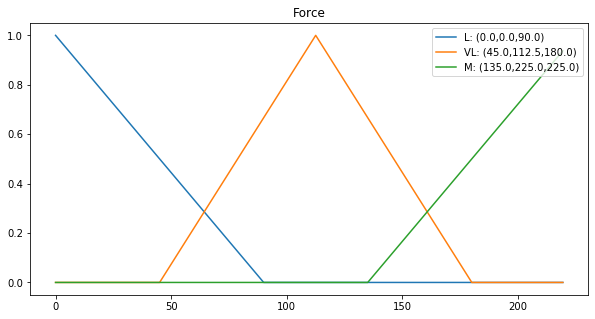

In [21]:
force = Premise(universe_name='Force', min_value=0.0, max_value=225.0)
force.auto_memberships(labels=['L', 'VL', 'M'])
force.plot()

### Fuzzy - NN

In [105]:
class FuzzyNN(nn.Module):
    
    def __init__(self, premises, n_out=1):
        super().__init__()
        self.premises = nn.ModuleList()
        self.n_rules = 1
        for premise in premises:
            self.premises.add_module(premise.universe_name, premise)
            self.n_rules = len(premise.memberships) * self.n_rules            
        self.consequence = nn.Linear(in_features=self.n_rules, out_features=n_out)
        nn.init.kaiming_normal_(self.consequence.weight)

    
    def forward(self, x):
        # Fuzzyfication and Rules
        for i, premise in enumerate(self.premises):
            
            print(premise.universe_name, x[:, i])
            prem_out = premise(x[:, i])
            if i == 0:
                out = prem_out.T
            else:
                out = (prem_out @ out).view(1,-1)
        # Consequence
        out = self.consequence(out)
        return out
    
    def plot(self):
        for premise in self.premises:
            premise.plot()
    

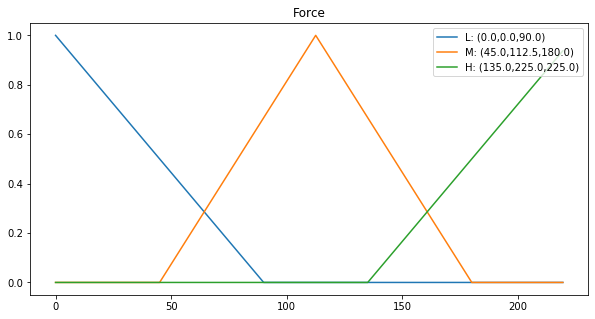

In [23]:
force = Premise(universe_name='Force', min_value=0.0, max_value=225.0)
force.auto_memberships(labels=['L', 'M', 'H'])
force.plot()

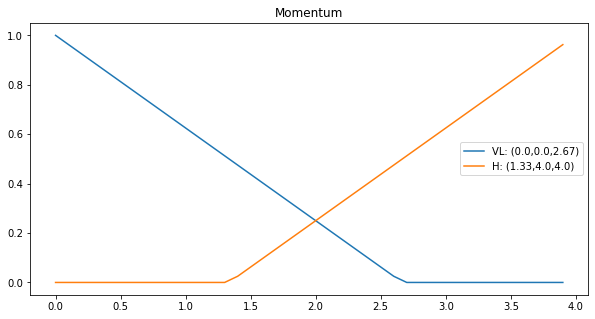

In [24]:
momentum = Premise(universe_name='Momentum', min_value=0.0, max_value=4.0)
momentum.auto_memberships(labels=['VL', 'H'])
momentum.plot()

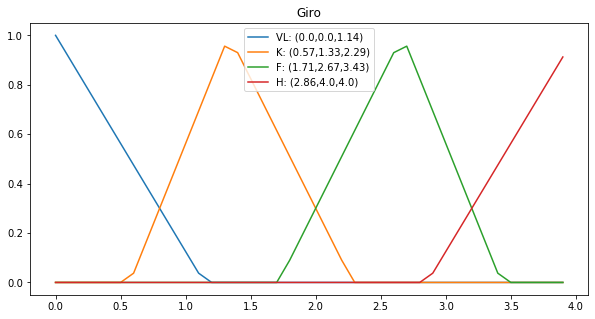

In [25]:
giro = Premise(universe_name='Giro', min_value=0.0, max_value=4.0)
giro.auto_memberships(labels=['VL', 'K', 'F', 'H'])
giro.plot()

In [26]:
fuzzyNN = FuzzyNN(premises=[force, momentum, giro], n_out=2)
print(fuzzyNN)

FuzzyNN(
  (premises): ModuleList(
    (Force): Premise(
      (memberships): ModuleList(
        (L): MembershipTriangular(
          (min): Point()
          (central): Point()
          (max): Point()
        )
        (M): MembershipTriangular(
          (min): Point()
          (central): Point()
          (max): Point()
        )
        (H): MembershipTriangular(
          (min): Point()
          (central): Point()
          (max): Point()
        )
      )
    )
    (Momentum): Premise(
      (memberships): ModuleList(
        (VL): MembershipTriangular(
          (min): Point()
          (central): Point()
          (max): Point()
        )
        (H): MembershipTriangular(
          (min): Point()
          (central): Point()
          (max): Point()
        )
      )
    )
    (Giro): Premise(
      (memberships): ModuleList(
        (VL): MembershipTriangular(
          (min): Point()
          (central): Point()
          (max): Point()
        )
        (K): MembershipT

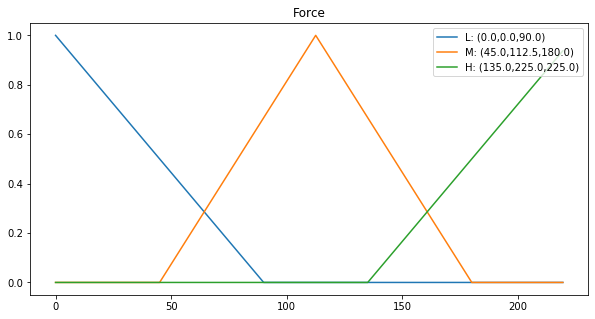

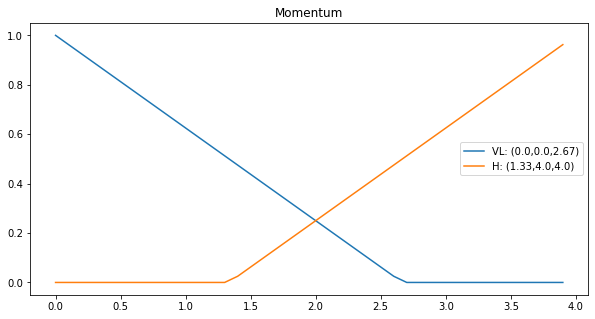

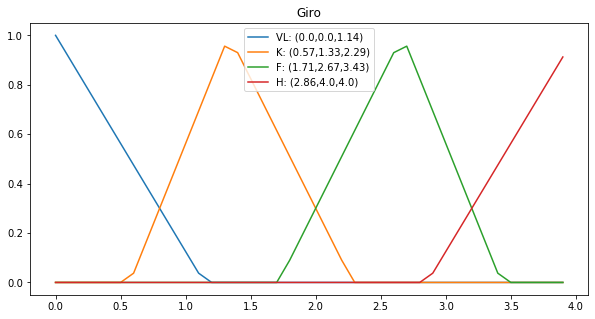

In [27]:
fuzzyNN.plot()

In [28]:
def check_params_device(model):
    for name, param in model.named_parameters():
        print(f'{name} is cuda: {param.is_cuda}')

In [29]:
check_params_device(fuzzyNN)

premises.Force.memberships.L.min.x is cuda: False
premises.Force.memberships.L.central.x is cuda: False
premises.Force.memberships.L.max.x is cuda: False
premises.Force.memberships.M.min.x is cuda: False
premises.Force.memberships.M.central.x is cuda: False
premises.Force.memberships.M.max.x is cuda: False
premises.Force.memberships.H.min.x is cuda: False
premises.Force.memberships.H.central.x is cuda: False
premises.Force.memberships.H.max.x is cuda: False
premises.Momentum.memberships.VL.min.x is cuda: False
premises.Momentum.memberships.VL.central.x is cuda: False
premises.Momentum.memberships.VL.max.x is cuda: False
premises.Momentum.memberships.H.min.x is cuda: False
premises.Momentum.memberships.H.central.x is cuda: False
premises.Momentum.memberships.H.max.x is cuda: False
premises.Giro.memberships.VL.min.x is cuda: False
premises.Giro.memberships.VL.central.x is cuda: False
premises.Giro.memberships.VL.max.x is cuda: False
premises.Giro.memberships.K.min.x is cuda: False
premis

In [30]:
fuzzyNN.to(device)

FuzzyNN(
  (premises): ModuleList(
    (Force): Premise(
      (memberships): ModuleList(
        (L): MembershipTriangular(
          (min): Point()
          (central): Point()
          (max): Point()
        )
        (M): MembershipTriangular(
          (min): Point()
          (central): Point()
          (max): Point()
        )
        (H): MembershipTriangular(
          (min): Point()
          (central): Point()
          (max): Point()
        )
      )
    )
    (Momentum): Premise(
      (memberships): ModuleList(
        (VL): MembershipTriangular(
          (min): Point()
          (central): Point()
          (max): Point()
        )
        (H): MembershipTriangular(
          (min): Point()
          (central): Point()
          (max): Point()
        )
      )
    )
    (Giro): Premise(
      (memberships): ModuleList(
        (VL): MembershipTriangular(
          (min): Point()
          (central): Point()
          (max): Point()
        )
        (K): MembershipT

In [31]:
check_params_device(fuzzyNN)

premises.Force.memberships.L.min.x is cuda: True
premises.Force.memberships.L.central.x is cuda: True
premises.Force.memberships.L.max.x is cuda: True
premises.Force.memberships.M.min.x is cuda: True
premises.Force.memberships.M.central.x is cuda: True
premises.Force.memberships.M.max.x is cuda: True
premises.Force.memberships.H.min.x is cuda: True
premises.Force.memberships.H.central.x is cuda: True
premises.Force.memberships.H.max.x is cuda: True
premises.Momentum.memberships.VL.min.x is cuda: True
premises.Momentum.memberships.VL.central.x is cuda: True
premises.Momentum.memberships.VL.max.x is cuda: True
premises.Momentum.memberships.H.min.x is cuda: True
premises.Momentum.memberships.H.central.x is cuda: True
premises.Momentum.memberships.H.max.x is cuda: True
premises.Giro.memberships.VL.min.x is cuda: True
premises.Giro.memberships.VL.central.x is cuda: True
premises.Giro.memberships.VL.max.x is cuda: True
premises.Giro.memberships.K.min.x is cuda: True
premises.Giro.memberships

In [32]:
inputs = torch.Tensor([[220.0, 1.8, 3.5999]]).to(device)

In [33]:
fuzzyNN(inputs)

Force tensor([220.], device='cuda:0')
Momentum tensor([1.8000], device='cuda:0')
Giro tensor([3.5999], device='cuda:0')
salida tensor([[-0.2750, -0.1467]], device='cuda:0', grad_fn=<AddmmBackward>)


tensor([[-0.2750, -0.1467]], device='cuda:0', grad_fn=<AddmmBackward>)

### TESTING FuzzyNN at CartPole

#### Cart Pole description:
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum starts upright, and the goal is to prevent it from falling over by increasing and reducing the cart's velocity.

#### State Space:
0. Cart Position [-2.4, 2.4]
1. Cart Velocity [-inf, inf]
2. Pole Angle [-0.481, 0.481]
3. Pole Velocity At Tip [-inf, inf]

![Cart Pole](./imgs/cartpole.png)

#### Action Space:
There are 2 posible actions: push left (0), push right (1).

#### Reward:
+1 for every step taken, including the termination step.

#### Episode termination:
1. Pole Angle is more than +-12*
2. Cart Position is more than +-2.4
3. Episode Length is greater than 200 (500 for v1)

#### Solved Requirements:
Consider solved when the average reward is greater than or equal to 195.0 over 100 consecutive trials.

### Playing CartPole

In [41]:
env = gym.make('CartPole-v0')

In [102]:
def test_policy(select_action, render=False):
    TOTAL_EPISODES = 20
    
    rewards = []
    for i_episode in range(TOTAL_EPISODES):
        episode_rwd = 0.0
        done = False
        observation = env.reset()
        
        while not done:    
            if render: env.render()
            action = select_action(observation)
            observation, reward, done, info = env.step(action)
            episode_rwd += reward

        rewards.append(episode_rwd)
    
    fig, ax = plt.subplots(1)
    ax.plot(rewards)
    ax.set_title(f"Average reward: {np.array(rewards).mean()}.")
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Cumulative reward')
    ax.set_xticks(range(TOTAL_EPISODES))
    env.close()

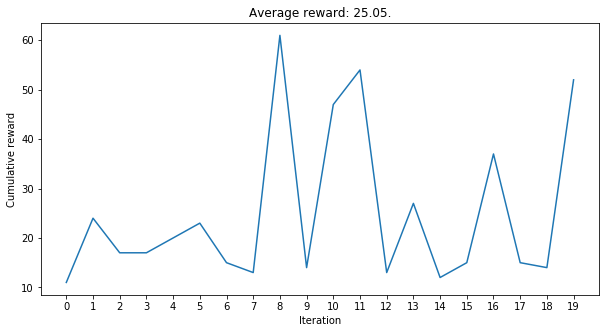

In [103]:
def random_action_selection(obs):
    return env.action_space.sample()

test_policy(random_action_selection)

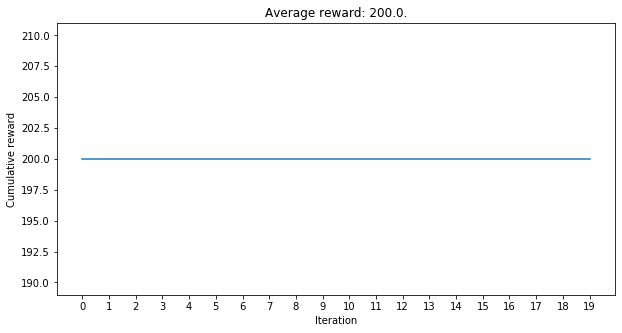

In [104]:
# https://towardsdatascience.com/how-to-beat-the-cartpole-game-in-5-lines-5ab4e738c93f

def optimal_action_selection(obs):
    cart_position, cart_velocity, pole_angle, pole_velocity = obs
    if abs(pole_angle) < 0.03:
        return 0 if pole_velocity < 0 else 1
    else:
        return 0 if pole_angle < 0 else 1

test_policy(optimal_action_selection)

### Could we ajdust our FuzzyNN weights to resemble the optimal policy?? 

First we define the premises: pole angle and pole velocity

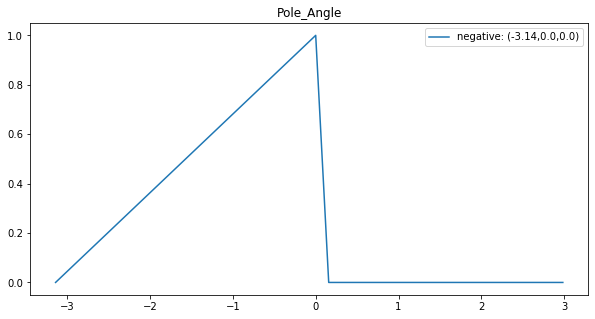

In [109]:
pole_angle = Premise(universe_name='Pole_Angle', min_value=-3.1415, max_value=3.1415)
pole_angle.add_membership(label='negative', min_value=-3.1415, central_value=0.0, max_value=0.0)

pole_angle.plot()